In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import os
import random
import pickle
import cv2 
# from sklearn.decomposition import PCA
# from libs import vgg16 # Download here! https://github.com/pkmital/CADL/tree/master/session-4/libs
# from libs import gif

PATH_LABELS = '/home/roland/datasets/celebrity_dataset/list_attr_celeba.txt'
PATH_IMAGES = '/home/roland/datasets/celebrity_dataset/img_align_celeba/'
face_cascade = cv2.CascadeClassifier('/home/roland/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/home/roland/opencv/data/haarcascades/haarcascade_eye.xml')

IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
COLOR_CHANNEL_COUNT = 3
MAXANGLE = 45.0
ZOOMFACTOR = 0.3
MAX_TRANSLATION = 25

def get_labels_attributes_and_filenames(labels_filepath):
    txt = open(labels_filepath).readlines()
    n_els = int(txt[0].strip())
    labels = txt[1].strip().split()
    n_labels = len(labels)
    attributes = np.zeros((n_els, n_labels), dtype=bool)
    filenames = []
    for i, txt_i in enumerate(txt[2:]):
        attributes[i] = (np.array(txt_i.strip().split()[1:]).astype(int) > 0)
        filenames.append(txt_i.strip().split()[0])
    return labels,attributes,filenames
labels, attributes, filenames = get_labels_attributes_and_filenames(PATH_LABELS)
#pd.read_csv(labels, sep=' ')

In [2]:
print(labels)
# MALE = 20
# ATTRACTIVENESS = 2
ATTRACTIVE_IDX = 2


['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


# Representable training images
The celebrity image dataset has images that are aligned neatly in the center of the image. Unfortunately, on Tinder, most people taking a selfie do this in millions of ways. This means that we cant just train on perfect images and release our algorithm in the wild. Actually, we can, but results will be very unpredictable. As a funny note: I decided to try it, and my algorithm thoughed an image of a horse was a very beautiful person. 

To get more representable data I decided to: 
- mess up the alignment of the images by rotating and moving them
- use OpenCV facedetection to get the face back, and train on these images


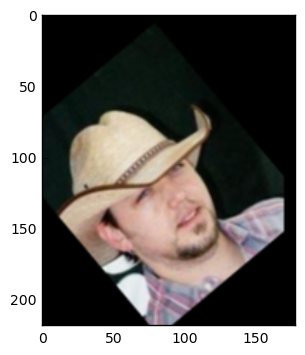

(218, 178, 3)


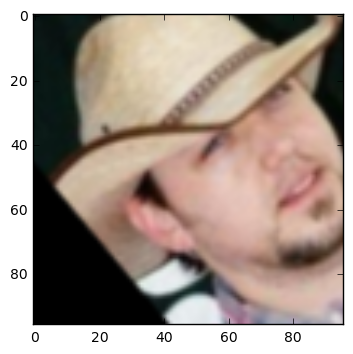

ugly!


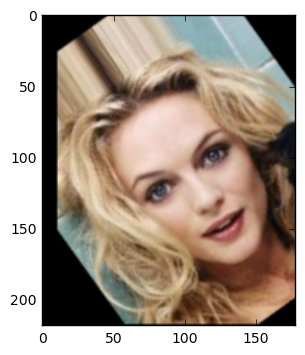

(218, 178, 3)


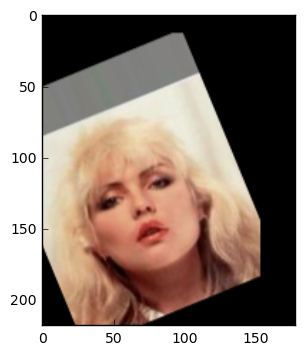

(218, 178, 3)


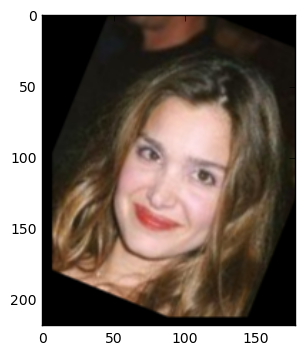

(218, 178, 3)


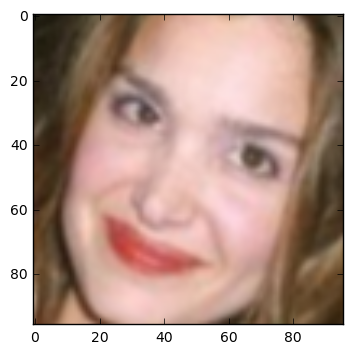

beauty!


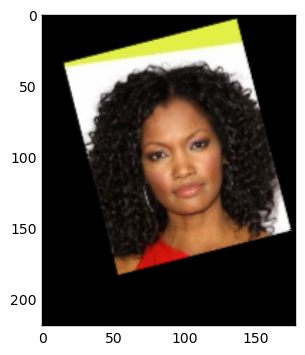

(218, 178, 3)


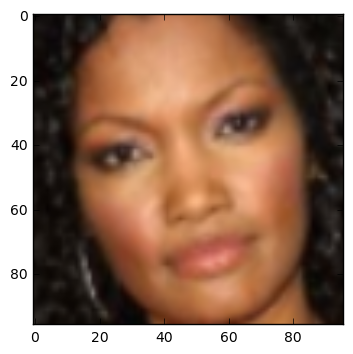

ugly!


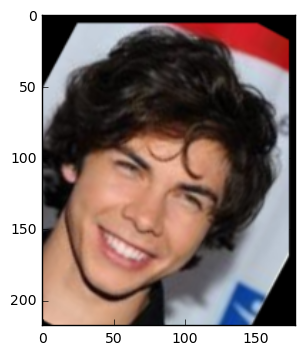

(218, 178, 3)


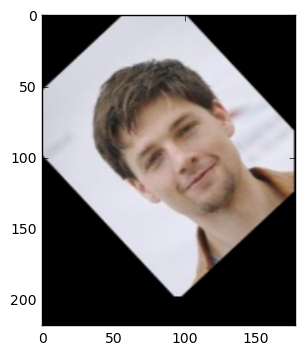

(218, 178, 3)


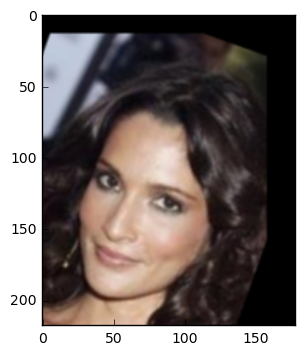

(218, 178, 3)


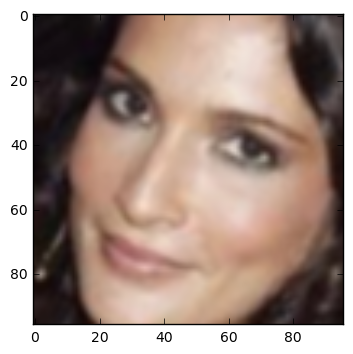

beauty!


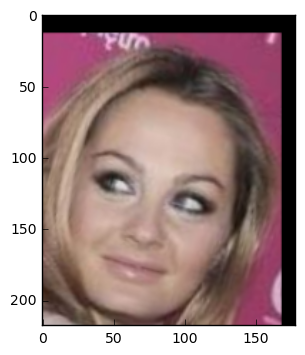

(218, 178, 3)


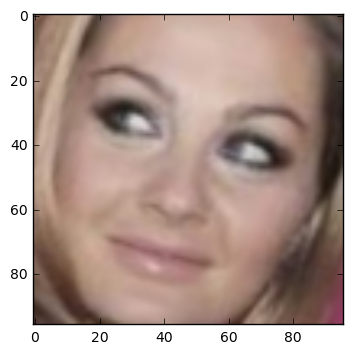

beauty!


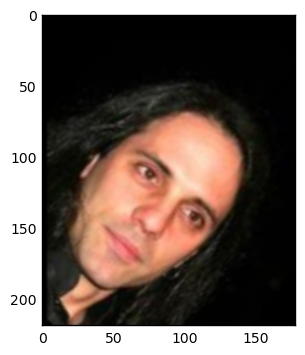

(218, 178, 3)


In [3]:

def get_random_image_and_is_pretty(filenames,attributes):
    index_image = random.randint(0,len(filenames)-1)
    name_picture = filenames[index_image]
    path_file = os.path.join(PATH_IMAGES,name_picture)
    image = plt.imread(path_file)
    return image,attributes[index_image][ATTRACTIVE_IDX]



def resize_image(image,width,height):
    """Resizes image"""
    return cv2.resize(image,(width,height))



def resize_image_by_cropping(image,width,height):
    """Resizes image by cropping the relevant part out of the image"""
    original_height = len(image)
    original_width = len(image[0])
    start_h = (original_height - height)//2
    start_w = (original_width - width)//2
    return image[start_h:start_h+height,start_w:start_w+width]


def zoom_and_rotate_image(image,zoom,angle):
    rows,cols,dimensions = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle*MAXANGLE, zoom)
    return cv2.warpAffine(image,M,(cols,rows))
def translate_image(image,translationx,translationy):
    rows,cols,dimensions = image.shape
    M = np.float32([[1,0,translationx],[0,1,translationy]])
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

def get_masks(image):
    themask = image==[0,0,0]
    invertedmask = image != [0,0,0]
    themask = themask[:,:,0]
    themask = themask.astype(dtype=np.uint8)
    invertedmask = invertedmask[:,:,0]
    invertedmask = invertedmask.astype(dtype=np.uint8)
    return themask,invertedmask


def adjust_image(image,angle,zoom,translationx,translationy):
    """each number is between -1 and 1"""
    rows,cols,dimensions = image.shape
    zoom = 1.0+ZOOMFACTOR*zoom
    difx = MAX_TRANSLATION*translationx
    dify = MAX_TRANSLATION*translationy
    rotated_image = zoom_and_rotate_image(image,zoom,angle)
    translated_image = translate_image(rotated_image,difx,dify)
    return translated_image


class ImageLoader:
    def get_random_images_from_set(self,count,names_images,attributes):
        Xs = []
        Ys = []
        for _ in range(count):           
            index = random.randint(0,len(names_images)-1)
            name_orig = os.path.join(self.path,names_images[index])
            loaded_image = plt.imread(name_orig)
           # resized_image = resize_image_by_cropping(loaded_image,IMAGE_WIDTH,IMAGE_HEIGHT)
            factors  = np.random.rand(4)
            factors-=0.5
            factors*=2 
            
            angle, zoom, translationx, translationy = factors
            
            resized_image = adjust_image(loaded_image,angle,zoom,translationx,translationy)
            
            
            Xs.append( resized_image)
            Ys.append( attributes[index][ATTRACTIVE_IDX])
        return np.array(Xs),np.array(Ys)
    
    def get_train_images(self,count):
        return self.get_random_images_from_set(count,self.trainimage_names,self.trainattributes)
    
    def get_test_images(self,count):
        return self.get_random_images_from_set(count,self.testimage_names,self.testattributes)
    
    def __init__(self,path,image_names,attributes,trainsplit_ratio=0.8):
        assert trainsplit_ratio > 0.0
        assert trainsplit_ratio < 1.0
        self.path = path
        self.trainimage_names = image_names[:int(trainsplit_ratio*len(image_names))]
        self.testimage_names = image_names[int(trainsplit_ratio*len(image_names)):]
        self.trainattributes = attributes[:int(trainsplit_ratio*len(image_names))]
        self.testattributes = attributes[:int(trainsplit_ratio*len(image_names))]
def extract_face_from_image(img):
    # either returns None or an image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.1,5,minSize=(64,64))
    roi_color = None
    if len(faces)==1:
        for (x,y,w,h) in faces:
            roi_color = np.copy(img[y:y+h, x:x+w])
    return roi_color
def extract_face_and_resize(image):
    extracted = extract_face_from_image(image)
    if extracted is None:
        return None
    
    extracted = resize_image(extracted,IMAGE_WIDTH,IMAGE_HEIGHT)
    return extracted
    
        
dataloader = ImageLoader(PATH_IMAGES,filenames,attributes)
images,ispretty = dataloader.get_train_images(10)

for i in range(len(images)):
    image,is_pretty = images[i],ispretty[i]
    plt.imshow(image)
    plt.show()
    print(image.shape)
   # print(image)
    
    image = extract_face_and_resize(image)
    if not image is None:
        plt.imshow(image)
        plt.show()
        if is_pretty:
            print("beauty!")
        else:
            print('ugly!')


In [4]:

def conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name,activation_function=tf.nn.relu,batch_normalise=True):
    with tf.variable_scope(scope_name):
        filter = tf.Variable(tf.random_normal([ksize,ksize,in_channels,out_channels],stddev=0.05))
        output = tf.nn.conv2d(input_image,filter, strides=[1, stride, stride, 1], padding='SAME')
        
        if batch_normalise:
            batch_mean2, batch_var2 = tf.nn.moments(output,[0])
            scale2 = tf.Variable(tf.ones([output.shape[1],output.shape[2],output.shape[3]]))
            beta2 = tf.Variable(tf.zeros([output.shape[1],output.shape[2],output.shape[3]]))
            epsilon = 0.001
            output = tf.nn.batch_normalization(output,batch_mean2,batch_var2,beta2,scale2,epsilon)

        if activation_function:
            output = activation_function(output)
        return output, filter
    
def residual_layer(input_image,ksize,in_channels,out_channels,stride,scope_name):
    with tf.variable_scope(scope_name):
        output,out_weights = conv_layer(input_image,ksize,in_channels,out_channels,stride,scope_name+"conv1")
        output,out_weights = conv_layer(output,ksize,out_channels,out_channels,stride,scope_name+"conv2")
        cool_stuff = tf.add(output,tf.identity(input_image))
        return cool_stuff,out_weights
    
def transpose_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output = tf.nn.relu(output)
        return output
    
def resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    with tf.variable_scope(scope_name):
        output = tf.image.resize_images(input_tensor,(new_shape[1],new_shape[2]))#tf.nn.conv2d_transpose(input_tensor, used_weights, output_shape=new_shape,strides=[1,stride,stride,1], padding='SAME')
        output, unused_weights = conv_layer(output,3,new_shape[3]*2,new_shape[3],1,scope_name+"_awesome_deconv")
        return output

def deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name):
    return resize_deconvolution_layer(input_tensor,used_weights,new_shape,stride,scope_name)


def output_between_zero_and_one(output):
    output +=1 
    return output/2

In [5]:
input_placeholder = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT,IMAGE_WIDTH,COLOR_CHANNEL_COUNT])
output_placeholder = tf.placeholder(tf.float32,[None,1])
computed_batch_size = tf.shape(input_placeholder)[0]

conv1, conv1_weights = conv_layer(input_placeholder,5,COLOR_CHANNEL_COUNT,32,2,"conv1")
conv1 = tf.nn.max_pool(conv1, [1,2,2,1], [1,2,2,1], 'SAME',name='only_maxpool_layer')


conv2, conv2_weights = conv_layer(conv1,3,32,32,2,"conv2")
conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], 'SAME',name='second_maxpool_layer')
conv3, conv3_weights = conv_layer(conv2,3,32,32,2,"conv3")
conv4, conv4_weights = conv_layer(conv3,3,32,16,2,"conv4")
conv5, conv5_weights = conv_layer(conv4,3,16,8,2,"conv5")
# res1, res1_weights = residual_layer(conv3,3,128,128,1,"res1")
# res2, res2_weights = residual_layer(res1,3,128,128,1,"res2")


last_conv_output = conv5
new_shape_length = last_conv_output.shape[1]*last_conv_output.shape[2]*last_conv_output.shape[3]
print(new_shape_length)
lin = tf.reshape(last_conv_output,[-1,int(new_shape_length)])



def linear_layer(input_tensor,output_size,scope_name,activation=tf.nn.relu):
    with tf.variable_scope(scope_name):
        assert len(input_tensor.shape)==2
        
        input_length =int(input_tensor.shape[1])
        
        weights = tf.Variable(tf.random_normal([input_length,output_size],stddev=0.3))
        biases = tf.Variable(tf.zeros([output_size]))
        out = tf.add(tf.matmul(input_tensor, weights), biases)
        
        if activation:
            out = activation(out)
        return out
#lin2 = linear_layer(lin,512,'first_linear',activation=tf.nn.tanh)
#lin3 = linear_layer(lin,32,'second_linear',activation=tf.nn.tanh)
lin4 = linear_layer(lin,10,'third_linear',activation=tf.nn.tanh)
lin5 = linear_layer(lin4,1,'last_linear',activation=tf.nn.tanh)
lin6 = output_between_zero_and_one(lin5)
print(lin6)
print(output_placeholder)
difference = output_placeholder-lin6


def calc_accuracy(predictions,truth):
    """Counts how often the prediction is closest to the truth value"""
    real_number = tf.cast((lin6+0.5),tf.int32)
    real_number_input = tf.cast(output_placeholder,tf.int32)
    accuracy_input = real_number - real_number_input # everything that is zero is good
    element_equal_to_value = tf.equal(accuracy_input,0)
    as_ints = tf.cast(element_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    accuracy = count/computed_batch_size
    return accuracy
accuracy = calc_accuracy(lin6,output_placeholder)

loss = tf.nn.l2_loss(difference)
optimizer = tf.train.AdamOptimizer().minimize(loss)

8
Tensor("truediv:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)


In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
print("done init")

done init


In [21]:
n_epochs = 50000
batch_size = 5
average_loss = 0
average_accuracy = 0
for epoch_i in range(n_epochs):
    in_x, in_y = dataloader.get_train_images(batch_size)
    new_x = []
    new_y = []
    for indx,image in enumerate(in_x):    
        image = extract_face_and_resize(image)
        if not image is None:
            new_x.append(image)
            new_y.append(in_y[indx])
    if len(new_x) ==0:
        continue
    in_x = np.array(new_x)
    in_y = new_y
    in_x = in_x/255
    
    in_y = np.array(in_y, dtype=bool)+0.0
    in_y = np.expand_dims(in_y,1)
    _,l,final_output,the_difference,the_accuracy = sess.run([optimizer,loss,lin6,difference,accuracy], feed_dict={input_placeholder:in_x ,output_placeholder: in_y })
    average_loss +=l
    average_accuracy += the_accuracy
   # print(l)
    
    if epoch_i % 100==1:
        print("epoch: " + str(epoch_i) + " loss: " + str(average_loss) + " accuracy: " + str(average_accuracy/100))
        average_accuracy = 0
        average_loss=l
#     #    plt.imshow(in_x[0])
#         plt.show()
#         #print(final_output)
#     #    print(in_y[0])
#         #print(the_difference)
        #print(final_output)

#         colored_images = sess.run(output, feed_dict={input_placeholder:test_x,output_placeholder:test_y})
#         generated = np.clip(colored_images,0.0,1.0)
#         generated = generated[0]
#         progress_images.append(generated)
#         if epoch_i < 800 or epoch_i > 19900:
#             show_progress(source_x[0],test_y[0],generated)


epoch: 1 loss: 0.948505282402 accuracy: 0.0075
epoch: 101 loss: 29.5192 accuracy: 0.514
epoch: 201 loss: 28.242 accuracy: 0.530666666667
epoch: 301 loss: 26.4546 accuracy: 0.584166666667
epoch: 401 loss: 31.2023 accuracy: 0.539833333333
epoch: 501 loss: 27.5093 accuracy: 0.559833333333
epoch: 601 loss: 28.2752 accuracy: 0.531
epoch: 701 loss: 26.9739 accuracy: 0.560666666667
epoch: 801 loss: 29.2596 accuracy: 0.5295
epoch: 901 loss: 31.0089 accuracy: 0.5245
epoch: 1001 loss: 27.4868 accuracy: 0.502166666667
epoch: 1101 loss: 28.1671 accuracy: 0.531
epoch: 1201 loss: 28.2909 accuracy: 0.608333333333
epoch: 1301 loss: 29.7006 accuracy: 0.514666666667
epoch: 1401 loss: 27.8848 accuracy: 0.6035
epoch: 1501 loss: 29.4154 accuracy: 0.551333333333
epoch: 1601 loss: 29.6416 accuracy: 0.552166666667
epoch: 1701 loss: 27.7065 accuracy: 0.573
epoch: 1801 loss: 30.1487 accuracy: 0.537666666667
epoch: 1901 loss: 27.6828 accuracy: 0.57
epoch: 2001 loss: 28.7507 accuracy: 0.527333333333
epoch: 2101 l

In [ ]:
print(final_output)
print(the_difference)
        
for i,image in enumerate(in_x):
    is_pretty = final_output[i][0]>0.5
    plt.imshow(image)
    plt.show()
    if is_pretty:
        print("beauty!")
    else:
        print('ugly!')

In [ ]:
import pynder
from libs import utils

information = {"facebook_token":"EAAGm0PX4ZCpsBAPqJYibZA9PLCZBOWljL733GlpUeiZBiflAvCfohaWbxpOLa8ZChFhpJLxrzPiZBYLK5NMSgGZCyA9rVFLPYZBDGGBsF1N2jvsuySPp46KFwEZATZCaxRhk6t6CNyzrtpODG3FEQMqcZA8IVZAE43FcPTKZA2oJZBMfnZCT54vdZBlHiuVzxgGlsBUc94G2RkS5ZBhZCNBHCWmdbHfh73","facebook_id":"808031619224368","locale":"en"}
facebook_id = information['facebook_id']
facebook_auth_token = information['facebook_token']
session = pynder.Session(facebook_id, facebook_auth_token)
print(session.matches()) # get users you have already been matched with
#session.update_location(LAT, LON) # updates latitude and longitude for your profile
print(session.profile)  # your profile. If you update its attributes they will be updated on Tinder.
users = session.nearby_users() # returns a list of users nearby

In [ ]:
def create_collage(images):
    fig = plt.figure()
    for index,image in enumerate(images):
        subplot_index = 100+10*len(images)+(index+1)
        plt.subplot(subplot_index)
        plt.imshow(image)
    plt.show()
def estimate_prettyness(user):
    images = []
    for photo_url in user.photos:
        path = utils.download(photo_url)
        image = plt.imread(path)
        image = resize_image(image,IMAGE_WIDTH,IMAGE_HEIGHT)
        images.append(image)


    input_network = np.array(images)
    beauty = sess.run(lin6, feed_dict={input_placeholder:input_network})
    create_collage(images)
    print(beauty)
    average_beauty = np.sum(beauty)/len(beauty)
    if average_beauty < 0.6:
        print("Too ugly! " + str(average_beauty))
        user.dislike()
    else:
        print("Very pretty! " + str(average_beauty))
        user.like()

    

for _ in range(3):
    users = session.nearby_users() # returns a list of users nearby
    for user in users:
        estimate_prettyness(user)
    
    
print(users)